# QNN - Initial draft

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
\newcommand{\ketbra}[2]{\left|{#1}\middle\rangle\langle{#2}\right|}
$$


In [1]:
import sys
stdout = sys.stdout
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi
from qiskit.visualization import plot_bloch_vector

import warnings
warnings.simplefilter('ignore')
plt.style.use('ggplot')


As shown in the previous two chapters, we have evaluated that the creation of quantum circuits to emulate binary addition and multiplication. While feasible, and a possible solution for future _Q-CPU_-only devices, if they ever come, their large growth makes them, currently, unable to efficiently emulate classical neurons from machine learning. 

To start, we will take a look at the proposed model shown by _Tacchino et al.[1](https://doi.org/10.1038/s41534-019-0140-4)_ and compare it to a classical model built with _(PyTorch)[https://pytorch.org/]_. For the purpose of comparison, we will use the simple _[IRIS-Dataset]()_

## Initial data analysis

To begin with, we will take a look at the dataset that is contained in `sklearn`.

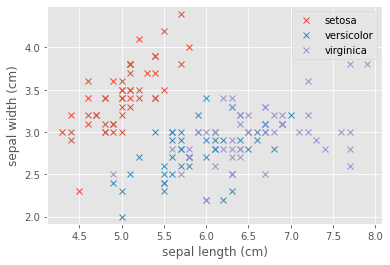

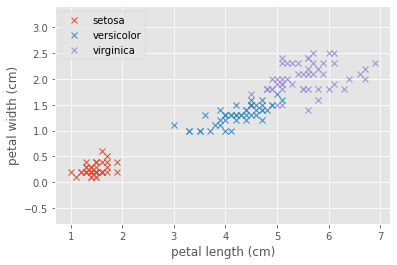

In [2]:
from sklearn.datasets import load_iris


# Load the data and split it up into usable chunks
dataset = load_iris()
data = dataset['data']
data_target = dataset['target']
target_names = dataset['target_names']
feature_names = dataset['feature_names']

for i in range(0,3,2):
    figure, axis = plt.subplots()
    for target, target_name in enumerate(target_names):
        X_plot = data[data_target == target]
        axis.plot(X_plot[:, i], X_plot[:, i+1], 
                linestyle='none', 
                marker='x', 
                label=target_name)
    axis.set_xlabel(feature_names[i])
    axis.set_ylabel(feature_names[i+1])
    axis.axis('equal')
    axis.legend();

## PyTorch model

In [3]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torchviz import make_dot


#check if we can train on a GPU or if we have to rely on the CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In _PyTorch_, we have to create a class of our network so that we can instantate it Here we define a model with 1 input layer, 1 hidden layer and 1 output layer. The activation function from layer 1 to the hidden layer is a _relU_ function, and from the hidden layer to the output layer is a _softmax_ function.

In [4]:
class IrisNetwork(nn.Module):
    def __init__(self):
        super(IrisNetwork, self).__init__()
        self.layer1 = nn.Linear(4, 4)
        self.layer2 = nn.Linear(4, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=1)
        return x

def get_pytorch_model():
    return IrisNetwork().to(device)

When training a model, it is necessary to split the existing data into 2 datasets: testing and training. For this we have to normalize the data beforehand using `sklearn.preprocessing.StandardScaler()` To make the tests reproducible, we also define a _seed_.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Now we normalize the data, this is specially important for the QNN
scaled_data = StandardScaler().fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_data, data_target, test_size=0.2, random_state=42)

Now to testing. In Pytorch, we need to define the type of variable used in the separate datasets, as right now they are in the numpy format. For example:

_X\_train_ is the input dataset of the 4 attributes. Its format is _long_

In [6]:
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


In [7]:
import tqdm

EPOCHS = 300
ALPHA = 0.001

loss_over_epochs     = np.zeros((EPOCHS,))
accuracy_over_epochs = np.zeros((EPOCHS,))

model = get_pytorch_model()
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
loss_fn   = nn.CrossEntropyLoss()


for epoch in tqdm.trange(EPOCHS):
    prediction = model(X_train)
    loss = loss_fn(prediction, y_train)
    loss_over_epochs[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_over_epochs[epoch] = correct.mean()

100%|██████████| 300/300 [00:00<00:00, 902.93it/s]


Achieved accuravy of: 0.699999988079071


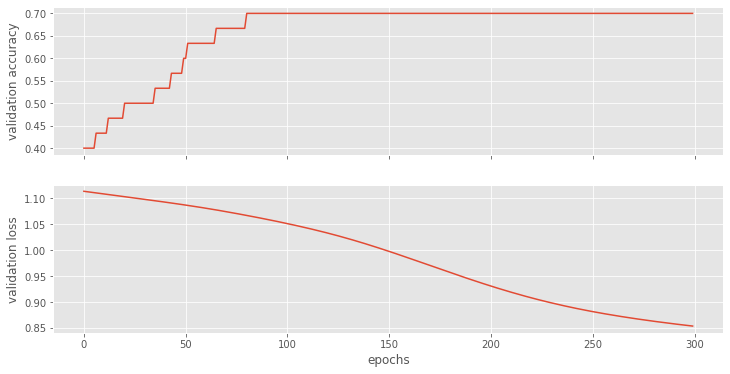

In [8]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_over_epochs)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_over_epochs)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

nn_accuracy = accuracy_over_epochs[-1]
print('Achieved accuravy of: ' + str(nn_accuracy))

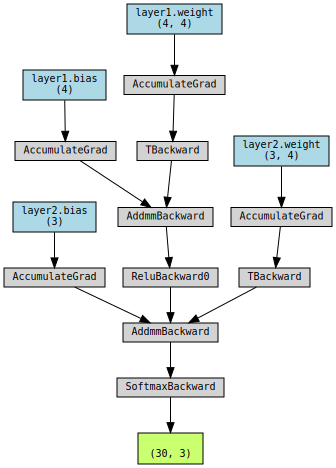

In [9]:
#Lets draw the NN
make_dot(model(X_test), params=dict(model.named_parameters()))

## Qiskit model

We will now try to build an equivalent model using qiskit, based on the purposal by _Tacchino et al._, as well as the _[supplementary data](https://iopscience.iop.org/article/10.1088/2058-9565/abb8e4)_. The initial input layer can be described as vector $\vec{i}$, and the weights as vector $\vec{w}$, where $n$ is the amount of nodes

$$
\vec{i} =\ \begin{pmatrix} i_0 \\ : \\ : \\ i_{m-1}\end{pmatrix} \\
$$

$$
\vec{w} =\ \begin{pmatrix} w_0 \\ : \\ : \\ w_{m-1}\end{pmatrix} \\
$$

In this scenario, $i_{n}$ and $w_{n} $\in \{-1,1\}$. This can be seen as factors for $x\pi$ rotiations, where $1\pi =\ 180°$ and $-1\pi =\ -180°$ . As the example from scenario from _[Tacchino et al.]_ was about an image that was binary encoded ($0 \rightarrow -1, 1 \rightarrow 1$), it fitted his problem well. For our situation, we can take a look at the _scaled data_ from the iris set.

In [10]:
print(scaled_data)

[[-9.00681170e-01  1.01900435e+00 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00 -1.31979479e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.38535265e+00  3.28414053e-01 -1.39706395e+00 -1.31544430e+00]
 [-1.50652052e+00  9.82172869e-02 -1.28338910e+00 -1.31544430e+00]
 [-1.02184904e+00  1.24920112e+00 -1.34022653e+00 -1.31544430e+00]
 [-5.37177559e-01  1.93979142e+00 -1.16971425e+00 -1.05217993e+00]
 [-1.50652052e+00  7.88807586e-01 -1.34022653e+00 -1.18381211e+00]
 [-1.02184904e+00  7.88807586e-01 -1.28338910e+00 -1.31544430e+00]
 [-1.74885626e+00 -3.62176246e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00  9.82172869e-02 -1.28338910e+00 -1.44707648e+00]
 [-5.37177559e-01  1.47939788e+00 -1.28338910e+00 -1.31544430e+00]
 [-1.26418478e+00  7.88807586e-01 -1.22655167e+00 -1.31544430e+00]
 [-1.26418478e+00 -1.31979479e-01 -1.34022653e+00 -1.44707648e+00]
 [-1.87002413e+00 -1.31979479e-01 -1.51073881e+00 -1.44707648e+00]
 [-5.25060772e-02  2.16998818e+00 -1.45390138e+00 -1.31544430e

As is observable, we have a range of values from -1 up to 1. This is dictated by our data, but not a problem _per se_. As we are working with rotations, any element $x \in data_{scaled}$ can be applied to $x\pi$ to achieve a rotation in $[-180°, 180°]$

Apart from this we also have a change in output size. Where _Tacchino et al._ were only interested if there is or isn't an edge in the image, we want to be able to give out probabilities for the type or _iris_ we are trying to perceive. In their paper, the application of _Z_ gates is done depending on _if the given value_ $i_{n}$ or $i_{m}$ is $1$ or $-1$. As $data_{scaled}$ contains a wider range of values, we will focus on applying the appropriate rotation to all _qubits_. The same rule is give for the applied $C^PZ$ gates. As these were somewhat dictate by the given values, which in our case doesn't hold up, we will apply the proposed ideas of _[Rossi at al.]_. These handle the connection of hypergraphs trough the usage of $C^PZ$ gates, wherever there is a connection between a node.

It is unclear wether our dataset has a background graph that connects the attributes with eachother using weights, but as seen by the previous example using a classical neural network, the results are promising. As there is no discrete data avaliable on the connection, we will evaluate different circuit designs. Let us assume that

$$
i_0 =\ \text{sepal width} \\
i_1 =\ \text{sepal length} \\
i_2 =\ \text{petal width} \\
i_3 =\ \text{petal length} \\
$$

Then we can expect that there is a correlation of the _setal_ attributes and _petal_ attributes. The first experiment will therefor use two $C^2Z$ gates applied accross $i_0 \rightarrow i_1$ and $i_2 \rightarrow i_3$. This concludes the $U_i$ layer of our network.

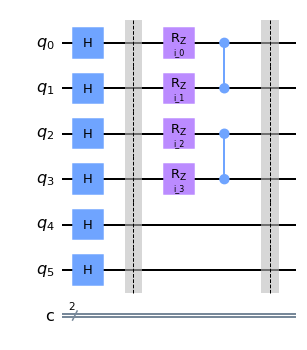

In [37]:
circuit = QuantumCircuit(6,2)
circuit.h(range(6))
circuit.barrier()
circuit.rz(Parameter('i_0'),0)
circuit.rz(Parameter('i_1'),1)
circuit.rz(Parameter('i_2'),2)
circuit.rz(Parameter('i_3'),3)
circuit.cz(0,1)
circuit.cz(2,3)
circuit.barrier()
circuit.draw('mpl')

The next step is building $U_w$ that is used to encode the trainable weights onto the circuit. When observing a classical neural network, we have interconnected layers with weights applied to them. To allow us to have 3 possible outputs, have to apply $C^PZ$ gates over all values to the corresponding output qubits.

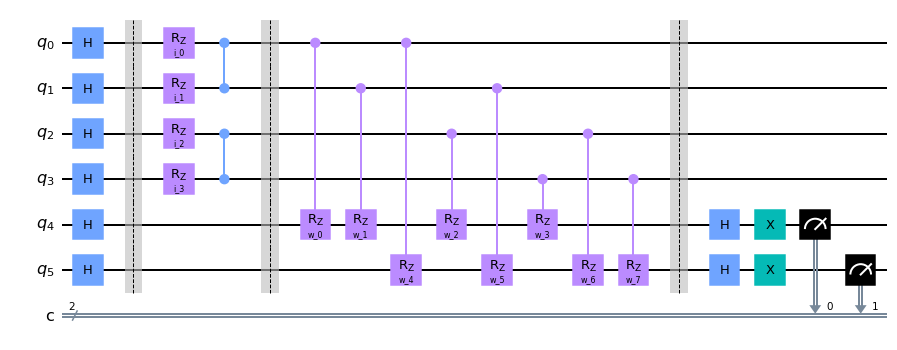

In [38]:
circuit.crz(Parameter('w_0'),0,4)
circuit.crz(Parameter('w_1'),1,4)
circuit.crz(Parameter('w_2'),2,4)
circuit.crz(Parameter('w_3'),3,4)

circuit.crz(Parameter('w_4'),0,5)
circuit.crz(Parameter('w_5'),1,5)
circuit.crz(Parameter('w_6'),2,5)
circuit.crz(Parameter('w_7'),3,5)
circuit.barrier()
circuit.h([4,5])
circuit.x([4,5])
circuit.measure([4,5], range(2))
circuit.draw('mpl')

To optimize the parameters, we will use the exact same functionality of PyTorch used in the classical example. First we have to create a parameter tensor for the qnn and initiate it. We will use a random parameter list betwen $-1$ and $1$

In [34]:
qnn_tensor = torch.empty(2, 4)
for i in range(len(qnn_tensor)):
    for j in range(len(qnn_tensor[i])):
        qnn_tensor[i][j] = 2 * np.random.random_sample() - 1

In [43]:
# This function turns the input attributes of the IRIS dataset as well as the tensor data from PyTorch into an array 
# This array can then be used in the parameterized QNN circuit
def create_parameters(input, tensor):
    parameters = []
    for val in input:
        parameters.append(val.item())
    for arr in tensor:
        for val in arr:
            parameters.append(val.item())
    return parameters

def turn_counts_into_probabilities(counts):
    values = list(counts.values())
    total = np.sum(values)
    for (k,v) in counts.items():
        counts[k] = v/total
    return counts

# we now need a special function to loop over the QNN and collect the results. These can then be fed back into the optimizer 
def predict_with_qnn(circuit, tensor, data):
    simulator = QasmSimulator()
    prediction = torch.empty(len(data), 3)
    for i, input in enumerate(data):
        parameters = create_parameters(input, tensor)
        qn = circuit.bind_parameters(parameters)
        compiled_circuit = transpile(qn, simulator)
        job = simulator.run(compiled_circuit, shots=100)
        result = job.result()
        counts = result.get_counts(qn)
        if '00' in counts:
            del counts['00']
        for k in ['01', '10', '11']:
            if k not in counts:
                counts[k] = 0
        probabilities = turn_counts_into_probabilities(counts)
        prediction[i] = torch.FloatTensor(list(probabilities.values()))
    return prediction

In [44]:
loss_over_epochs_quantum    = np.zeros((EPOCHS,))
accuracy_over_epochs_quantum = np.zeros((EPOCHS,))


optimizer = torch.optim.Adam([qnn_tensor], lr=ALPHA)
loss_fn   = nn.CrossEntropyLoss()



for epoch in tqdm.trange(EPOCHS):
    prediction = predict_with_qnn(circuit, qnn_tensor, X_train)
    loss = loss_fn(prediction, y_train)
    loss = Variable(loss, requires_grad=True)
    loss_over_epochs_quantum[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_over_epochs_quantum[epoch] = correct.mean()

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_over_epochs_quantum)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_over_epochs_quantum)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

qnn_accuracy = accuracy_over_epochs_quantum[-1]
print('Achieved accuravy of: ' + str(qnn_accuracy))

 83%|████████▎ | 249/300 [1:02:25<12:50, 15.11s/it]

In [ ]:
ax1.plot(accuracy_over_epochs_quantum)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_over_epochs_quantum)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

qnn_accuracy = accuracy_over_epochs_quantum[-1]
print('Achieved accuravy of: ' + str(qnn_accuracy))

Another proposal of solving QNN, albeit in a more split fashion, is the model by _[Cao et al.](https://arxiv.org/abs/1711.11240)_. This architecture looks at replacing the neurons with quantum gates, whilst maintaining everything else in the classical solution.

### Bibliography

[1] Tacchino, F., Macchiavello, C., Gerace, D. et al. An artificial neuron implemented on an actual quantum processor. npj Quantum Inf **5**, 26 (2019). https://doi.org/10.1038/s41534-019-0140-4

[2] M. Rossi, M. Huber, D. Bruß, C. Macchiavello. Quantum Hypergraph States. New J. Phys. 15, 113022 (2013). https://arxiv.org/abs/1211.5554

[3] Yudong Cao, Gian Giacomo Guerreschi, Alán Aspuru-Guzik. arXiv:1711.11240 \[quant-ph\]. https://arxiv.org/abs/1711.11240